In [1]:
import sys

import polars as pl
import torch

from modeling_module.data_loader.MultiPartDataModule import MultiPartDataModule
from modeling_module.models.PatchMixer.common.configs import PatchMixerConfig
from modeling_module.models.PatchTST.common.configs import PatchTSTConfig, PatchTSTConfigWeekly
from modeling_module.utils.checkpoint import save_model_dict, load_model_dict

'''
pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128
https://developer.nvidia.com/cuda-12-8-0-download-archive
'''

MAC_DIR = '/Users/igwanhyeong/PycharmProjects/data_research/raw_data/'
WINDOW_DIR = 'C:/Users/USER/PycharmProjects/research/raw_data/'

if sys.platform == 'win32':
    DIR = WINDOW_DIR
    print(torch.cuda.is_available())
    print(torch.cuda.device_count())
    print(torch.version.cuda)
    print(torch.__version__)
    print(torch.cuda.get_device_name(0))
    print(torch.__version__)
else:
    DIR = MAC_DIR

save_dir = DIR + 'fit/20251110_running'


True
1
12.8
2.9.0.dev20250716+cu128
NVIDIA GeForce RTX 5080
2.9.0.dev20250716+cu128


In [2]:
target_dyn_demand_weekly = pl.read_parquet(DIR + 'target_dyn_demand_weekly.parquet').sort(['oper_part_no', 'demand_dt'])
target_dyn_demand_weekly = (target_dyn_demand_weekly.group_by('oper_part_no', maintain_order = True).map_groups(lambda g: g.with_columns(pl.arange(1, len(g) + 1).alias('seq'))))

filtered_target = target_dyn_demand_weekly.group_by('oper_part_no').agg(pl.col('seq').max().alias('seq_max')).filter(pl.col('seq_max') > 260).select('oper_part_no')

target_dyn_demand_weekly = target_dyn_demand_weekly.join(filtered_target, on = 'oper_part_no', how = 'right').select(['oper_part_no', 'demand_dt', 'demand_qty'])
target_dyn_demand_weekly

oper_part_no,demand_dt,demand_qty
str,i64,f64
"""T5525-85604""",201801,1.0
"""T5525-85604""",201803,1.0
"""T5525-85604""",201804,6.0
"""T5525-85604""",201807,4.0
"""T5525-85604""",201808,1.0
…,…,…
"""T2546-69061""",202653,20.0
"""T2546-69061""",202701,17.0
"""T2546-69061""",202702,2.0


In [3]:
plan_yyyymm = 201811
lookback = 52
horizon = 27
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

data_module = MultiPartDataModule(
    target_dyn_demand_weekly.sort(['oper_part_no', 'demand_dt']),
    lookback = lookback,
    horizon = horizon,
    batch_size = 64,
    val_ratio = 0.2,
    is_running = True
)

train_loader = data_module.get_train_loader()
val_loader = data_module.get_val_loader()

In [4]:
from modeling_module.training.model_trainers.total_train import run_total_train_weekly

mode_dict = run_total_train_weekly(
    train_loader,
    val_loader,
    lookback = lookback,
    horizon = horizon,
)

revin_use_std: False
revin_subtract_last True
final_clamp_nonneg True
Titan Base

[train_titan] ===== Stage 1/2 =====
  - spike: OFF
  - epochs: 10 | lr=0.0003 | horizon_decay=False
[train_titan] Effective TrainingConfig:
{
  "device": "cuda",
  "lookback": 52,
  "horizon": 27,
  "epochs": 10,
  "lr": 0.0003,
  "weight_decay": 0.001,
  "t_max": 40,
  "patience": 100,
  "max_grad_norm": 30.0,
  "amp_device": "cuda",
  "loss_mode": "point",
  "point_loss": "huber",
  "huber_delta": 0.8,
  "q_star": 0.5,
  "use_cost_q_star": false,
  "Cu": 1.0,
  "Co": 1.0,
  "quantiles": [
    0.1,
    0.5,
    0.9
  ],
  "use_intermittent": true,
  "alpha_zero": 3.0,
  "alpha_pos": 1.0,
  "gamma_run": 0.3,
  "cap": null,
  "use_horizon_decay": false,
  "tau_h": 0.85,
  "val_use_weights": false,
  "spike_loss": {
    "enabled": false,
    "strategy": "mix",
    "huber_delta": 0.6,
    "asym_up_weight": 1.0,
    "asym_down_weight": 8.0,
    "mad_k": 1.5,
    "w_spike": 32.0,
    "w_norm": 1.0,
    "alpha_

In [5]:
from modeling_module.models.Titan.common.configs import TitanConfig

pm_base_config = PatchMixerConfig(
        lookback = lookback,
        horizon = horizon,
        device = device,
        loss_mode = 'point',
        point_loss = 'mae'
    )

pm_quantile_config = PatchMixerConfig(
    lookback = lookback,
        horizon = horizon,
    device = device,
    loss_mode = 'quantile',
    quantiles = (0.1, 0.5, 0.9)
)

ti_config = TitanConfig(
            lookback=lookback,
            horizon=horizon,
            # 아래는 Titans.py에서 사용하는 공통 옵션들(필요 시 설정)
            input_dim=1,  # 데이터로더 입력 채널 수에 맞춰 조정
            d_model=256,
            n_layers=3,
            n_heads=4,
            d_ff=512,
            dropout=0.1,
            contextual_mem_size=256, persistent_mem_size=64,
            use_exogenous=True, exo_dim=2,  # 캘린더 sin/cos 자동 주입 조건
            final_clamp_nonneg=True,
        )
#
pt_config = PatchTSTConfig(
        device = device,
        loss_mode = 'auto',
        quantiles = (0.1, 0.5, 0.9)
    )

cfg_map = {
    # "PatchMixer Base": pm_base_config,
    # "PatchMixer Quantile": pm_quantile_config,
    "Titan Base": ti_config,
    # "Titan LMM": ti_config,
    # "Titan Seq2Seq": ti_config,
    # "PatchTST Base": pt_config,
    # "PatchTST Quantile": pt_config
}

In [6]:

models_only = {
    name: (pack["model"] if isinstance(pack, dict) and "model" in pack else pack)
    for name, pack in mode_dict.items()
}

# cfg_by_name도 맞춰서 준비(필요하면)
cfg_by_name = {
    name: (pack.get("cfg") if isinstance(pack, dict) else None)
    for name, pack in mode_dict.items()
}

builder_key_by_name = {
  # "PatchMixer Base": "patchmixer_base",
  # "PatchMixer Quantile": "patchmixer_quantile",
  "Titan Base": "titan_base",
  # "Titan LMM": "titan_lmm",
  # "Titan Seq2Seq": "titan_seq2seq",
  # "PatchTST Base": "patchtst_base",
  # "PatchTST Quantile": "patchtst_quantile",
}
save_index = save_model_dict(
    models_only,
    save_dir,
    cfg_by_name=cfg_by_name,                 # None 가능
    builder_key_by_name=builder_key_by_name  # 기존 그대로
)

In [7]:

# Load
from modeling_module.models.model_builder import (
    build_titan_base, build_titan_lmm, build_titan_seq2seq, build_patch_mixer_base, build_patch_mixer_quantile,
    build_patchTST_base, build_patchTST_quantile,
)

builders = {
    # "patchmixer_base": lambda cfg: build_patch_mixer_base(cfg or PatchMixerConfig()),
    # "patchmixer_quantile": lambda cfg: build_patch_mixer_quantile(cfg or PatchMixerConfig()),
    "titan_base": lambda cfg: build_titan_base(ti_config or TitanConfig()),
    # "titan_lmm": lambda cfg: build_titan_lmm(ti_config or TitanConfig()),
    # "titan_seq2seq": lambda cfg: build_titan_seq2seq(ti_config or TitanConfig()),
    # "patchtst_base": lambda cfg: build_patchTST_base(cfg or PatchTSTConfigWeekly()),
    # "patchtst_quantile": lambda cfg: build_patchTST_quantile(cfg or PatchTSTConfigWeekly()),
}
loaded = load_model_dict(save_dir, builders, device = device)

[load] titan_base ← C:/Users/USER/PycharmProjects/research/raw_data/fit/20251110_running\titan_base.pt
revin_use_std: False
revin_subtract_last True
final_clamp_nonneg True
[warn] TitanBaseModel: strict load failed → attempting adaptive remap
[load partial] titan_base: non-critical mismatch → partial load.


[PLOT-DBG] titan_base point(H=27): var(H)=103.418, mean(H)=14.2972, unique(H)=19
dict_items([('titan_base', array([18.749136, 19.346022, 21.11145 , 21.246801, 21.329283, 21.287584,
       21.764105, 23.182623,  0.      ,  0.      ,  0.      ,  0.      ,
       20.716965, 20.299706, 21.641619, 20.724257, 22.14549 , 22.16181 ,
       23.372728, 23.51441 ,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      , 19.950033, 23.48031 ], dtype=float32))])


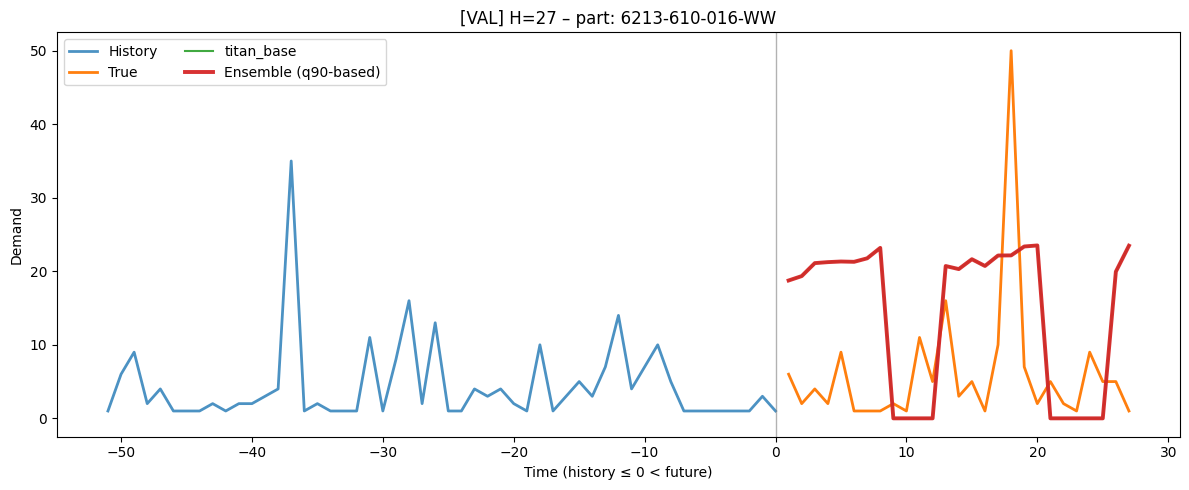

[PLOT-DBG] titan_base point(H=27): var(H)=551.952, mean(H)=37.243, unique(H)=21
dict_items([('titan_base', array([52.355583, 51.644253, 54.446022, 52.577694, 53.868664, 52.43772 ,
       52.881496, 55.952267,  0.      ,  0.      ,  0.      ,  0.      ,
       56.277164, 51.249317, 53.80092 , 52.650475, 54.367477, 54.333206,
       54.575615, 52.40714 ,  0.      ,  0.      , 12.648094,  0.      ,
       37.310886, 47.22493 , 52.551815], dtype=float32))])


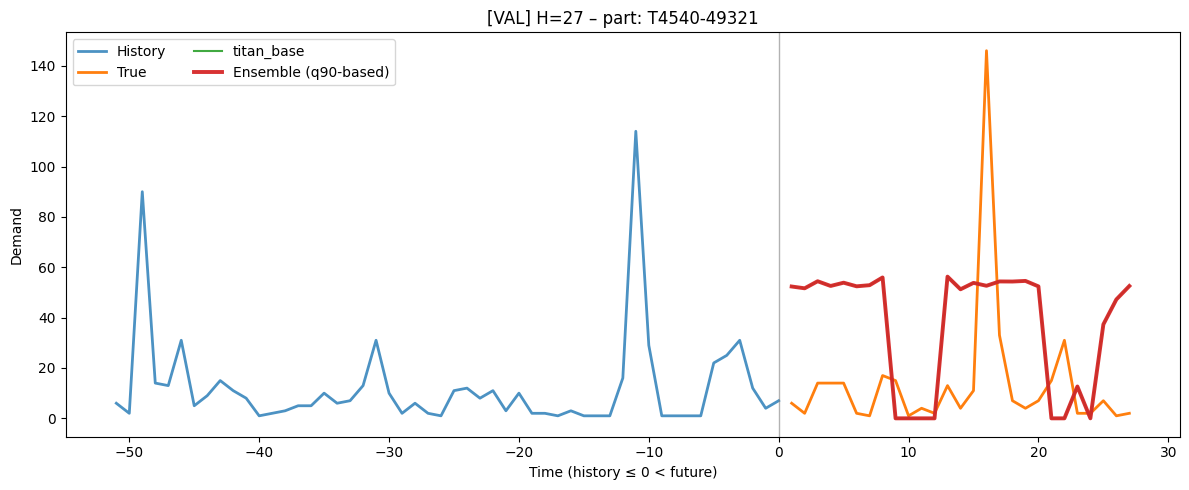

[PLOT-DBG] titan_base point(H=27): var(H)=439.02, mean(H)=31.909, unique(H)=21
dict_items([('titan_base', array([46.101917 , 45.4799   , 47.79878  , 45.3375   , 47.112614 ,
       46.108215 , 46.180492 , 48.06596  ,  0.       ,  0.       ,
        0.       ,  0.       , 49.55769  , 44.505726 , 47.218964 ,
       46.021484 , 47.759293 , 47.75317  , 47.806187 , 45.15642  ,
        0.       ,  0.       ,  1.8144951,  0.       , 26.52975  ,
       40.15075  , 45.084423 ], dtype=float32))])


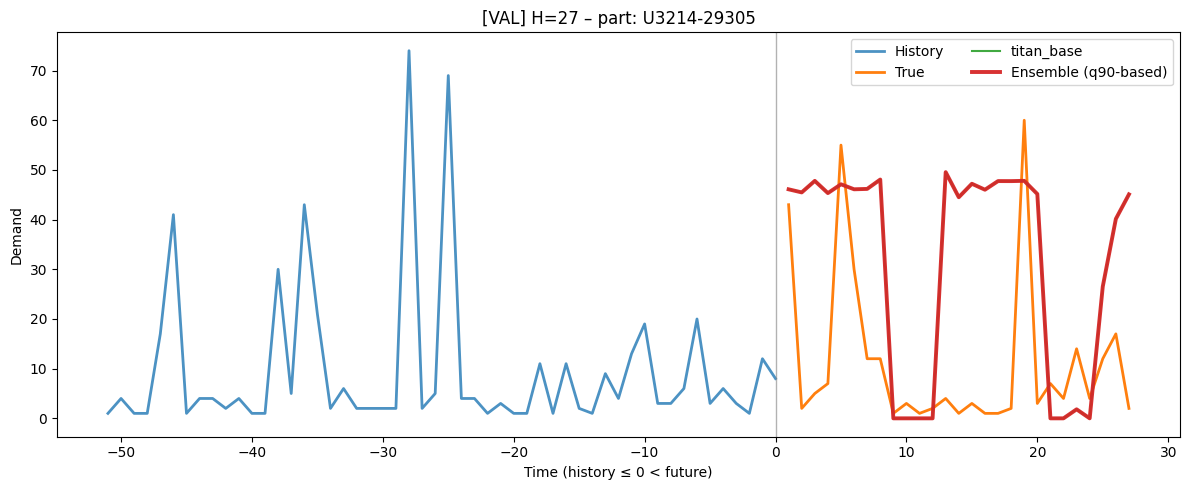

[PLOT-DBG] titan_base point(H=27): var(H)=72.0633, mean(H)=11.8956, unique(H)=19
dict_items([('titan_base', array([15.001455, 15.66936 , 17.4125  , 17.68656 , 17.677687, 17.65662 ,
       18.165533, 19.532675,  0.      ,  0.      ,  0.      ,  0.      ,
       16.882242, 16.69336 , 17.99829 , 17.076603, 18.499582, 18.525173,
       19.794203, 20.120697,  0.      ,  0.      ,  0.      ,  0.      ,
        0.      , 16.660685, 20.12744 ], dtype=float32))])


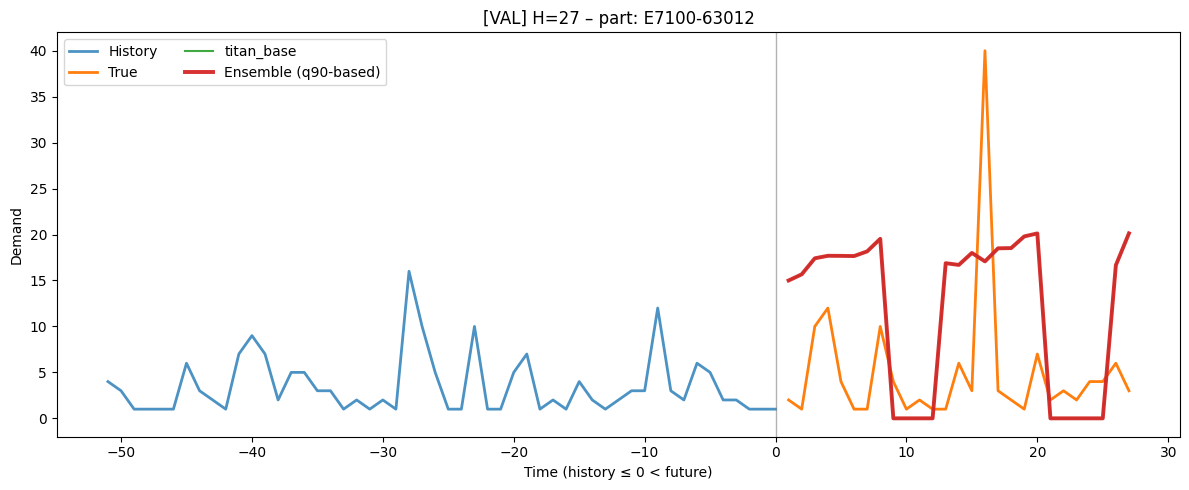

[PLOT-DBG] titan_base point(H=27): var(H)=766.488, mean(H)=230.403, unique(H)=27
dict_items([('titan_base', array([250.2967 , 247.4903 , 261.08044, 252.74509, 256.48737, 241.24637,
       248.39621, 265.0699 , 196.04718, 186.3241 , 192.69781, 195.16966,
       279.54413, 243.17128, 249.33957, 248.48062, 250.499  , 249.27185,
       242.90472, 219.25128, 186.61615, 189.53928, 203.52179, 190.91031,
       234.16667, 226.06912, 214.55537], dtype=float32))])


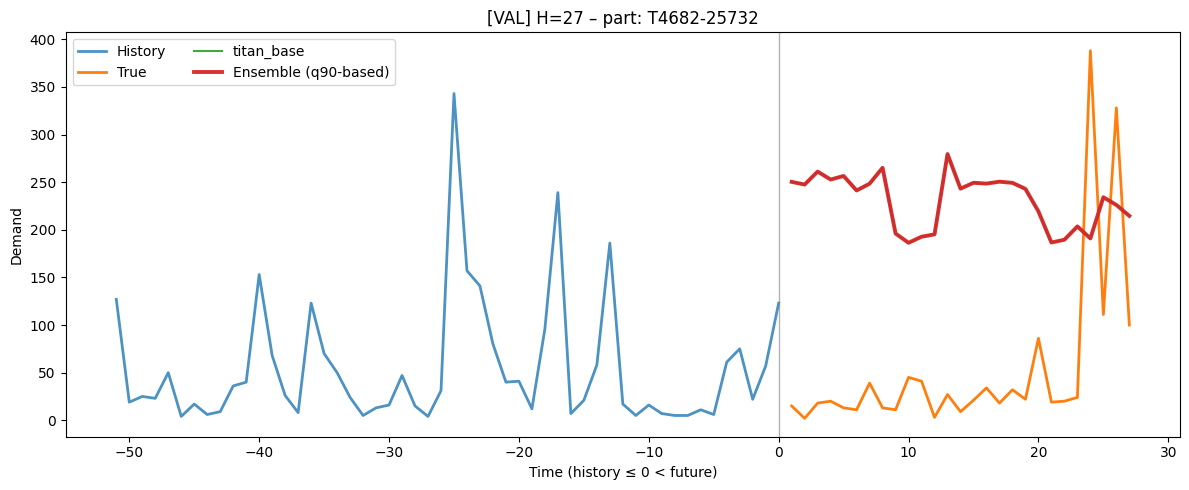

In [8]:
%load_ext autoreload
%autoreload 2

import importlib, modeling_module.utils.plot_utils as pu
import modeling_module.training.forecaster as fo
importlib.reload(pu)
importlib.reload(fo)

def my_exo_cb(start_idx: int, Hm: int, device="cuda" if torch.cuda.is_available() else "cpu"):
    # exo_dim = 2 (sin, cos)
    return fo.make_calendar_exo(start_idx, Hm, period=52, device=device)

pu.plot_27w(
    models=loaded,           # {"PatchMixer": pm_model, "Titan": ti_model, ...}
    loader=val_loader,       # (xb, yb[, part_ids])
    device="cuda" if torch.cuda.is_available() else "cpu",
    mode="val",              # ← 검증 모드
    max_plots=5,
    out_dir=None,
    show=True,
    future_exo_cb=None
)